In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist, jaccard, squareform
import matplotlib.pyplot as plt

# Default Python packages
import sys
from typing import Tuple, Any
from datetime import datetime

# Custom config class to globally change if we're debugging, running tests, running with fixed seeds
class Config:
    seed: int
    run_tests = bool
    fixed_seed: bool
    do_print: bool

Config.seed = 42
Config.fixed_seed = True
Config.run_tests = False
Config.do_print = True

# Please Run All cells now before reading on

## For peer-reviewing the report, scroll down to the H1 header "Start of Report"

You can also collapse the headers **Ingest data** and **Function implementations** to get there quickly

# Ingest data

In [2]:
# Ingest data
train_file_path = "lab2_train.csv"
test_file_path = "lab2_test.csv"

train_data = pd.read_csv(train_file_path, delimiter=",")
test_data = pd.read_csv(test_file_path, delimiter=",")

# Clean up test_data labels if necessary
train_data.rename(columns=str.strip, inplace=True)
test_data.rename(columns=str.strip, inplace=True)

# Function implementations

The functions below are for reference only. The WebLab functions are to be graded. These may have changed to accomodate our pipelines.

## Non-negative Matrix Factorisation implementation
### Provided design specification
Implement the `nmf()` subroutine in the provided code base. This function takes as input a matrix `X`, the number of required components `n` (“number of features” from the lecture), a maximum number of iterations, and an error tolerance threshold. It returns two matrices `W` and `H` (with width/height `n`) such that `WH` approximates `X`.

Use the algorithm from the lecture slides as the algorithm to compute `W` and `H`. For more information about it, you can read about it here.

If at a certain point in the algorithm the reconstruction error of each consecutive iteration is less than `tol`, then you can stop early.

`Hint: if at some place of the algorithm it's possible for a division by 0 to happen, add 1e-9 to the denominator.`


In [3]:
# Non-negative matrix factorisation implementation and tests

RUN_TESTS = True

def nmf(X: pd.DataFrame, n_components: int, max_iter: int=1000, tol: float=1e-3):
    """
    Decomposes the original sparse matrix X into two matrices W and H. 
    """
    # Initialize W and H with random non-negative values
    W = np.random.rand(X.shape[0], n_components)
    H = np.random.rand(n_components, X.shape[1])

    # START ANSWER
    V = X.to_numpy()
    e = 1e-99

    iteration = 0
    
    prev_error = None
    
    error = V - (W @ H)
    error = np.power(error, 2)
    error = np.trace(error)
    error = np.sqrt(error)
    error_diff = np.inf
    print(error_diff)
    
    while (error_diff > tol and iteration < max_iter):
        numerator = V @ H.T
        denominator = W @ H @ H.T
        division = numerator / (denominator + e)
        W = W * division

        numerator = W.T @ V
        denominator = W.T @ W @ H
        division = numerator / (denominator + e)
        H = H * division
        
        # Remember the error from previous iteration
        prev_error = error
        # Calculate reconstruction error
        error = V - (W @ H)
        error = np.power(error, 2)
        error = np.trace(error)
        error = np.sqrt(error)
        # Error differential
        error_diff = prev_error - error
        iteration += 1

    print(f"NMF optimized with {iteration} iterations and error of {error}")
    # V = X.to_numpy()
    # i = 0
    # E = np.inf
    # Enew = np.linalg.norm(V - W@H, 'fro')**2
    # print(E)
    # print(Enew)
    # while((E-Enew) > tol and i < max_iter): 
    #     i += 1
    #     W *= (V@H.T) / (W@H@H.T + 1e-9)
    #     H *= (W.T@V) / (W.T@W@H + 1e-9)

    #     E = Enew
    #     Enew = np.linalg.norm(V - W@H, 'fro')**2
    #     Enew = np.sqrt(Enew)
    # END ANSWER

    return W, H

if Config.run_tests:
    import unittest
    
    class TestSolution(unittest.TestCase):
        def setUp(self):
            np.random.seed(42)

        def test_2_by_2(self):
            col1 = [1, 1]
            col2 = [0, 0]
            sparse_matrix = pd.DataFrame(list(zip(col1, col2)))
            w, h = nmf(sparse_matrix, 4, 10)
            reconstructed_matrix = pd.DataFrame(data=np.dot(w, h),
                                                index=sparse_matrix.index,
                                                columns=sparse_matrix.columns)
            pd.testing.assert_frame_equal(sparse_matrix, reconstructed_matrix, check_dtype=False)

        def test_3_by_3(self):
            col1 = [1, 1, 0]
            col2 = [0, 0, 0]
            col3 = [0, 1, 0]
            sparse_matrix = pd.DataFrame(list(zip(col1, col2, col3)))
            w, h = nmf(sparse_matrix, 5, 50)
            reconstructed_matrix = pd.DataFrame(data=np.dot(w, h),
                                                index=sparse_matrix.index,
                                                columns=sparse_matrix.columns)
            pd.testing.assert_frame_equal(sparse_matrix, reconstructed_matrix, check_dtype=False, atol=0.05)

        def test_3_by_2(self):
            col1 = [0, 1, 0]
            col2 = [0, 0, 1]
            sparse_matrix = pd.DataFrame(list(zip(col1, col2)))
            w, h = nmf(sparse_matrix, 5, 50)
            reconstructed_matrix = pd.DataFrame(data=np.dot(w, h),
                                                index=sparse_matrix.index,
                                                columns=sparse_matrix.columns)
            pd.testing.assert_frame_equal(sparse_matrix, reconstructed_matrix, check_dtype=False, atol=0.05)

        def test_5_by_5(self):
            col1 = [0, 1, 0, 0, 0]
            col2 = [0, 0, 1, 1, 0]
            col3 = [0, 0, 0, 0, 0]
            col4 = [0, 1, 0, 0, 0]
            col5 = [1, 0, 0, 0, 0]
            sparse_matrix = pd.DataFrame(list(zip(col1, col2, col3, col4, col5)))
            w, h = nmf(sparse_matrix, 5, 50)
            reconstructed_matrix = pd.DataFrame(data=np.dot(w, h),
                                                index=sparse_matrix.index,
                                                columns=sparse_matrix.columns)
            pd.testing.assert_frame_equal(sparse_matrix, reconstructed_matrix, check_dtype=False, atol=0.05)

    unittest.main(argv=[''], verbosity=2, exit=False)

## MinHashing implementation
### Provided design specification
Implement the `compute_signature()` subroutine in the provided code base. This function takes as input a list of `k` `HashFunction` and a list of `n` sets of integers, representing which `ids` each user has liked.

Have a look in the library to see how `HashFunction` is defined.

It should return the minhash signature for the given input, when applying the provided hash functions. The signature should be of size `k x n`, where each column of the signature matrix represents the index of the user’s liked ids, and the rows represent the index of each hash function.

The goal is for similar sets of liked `ids` to have similar columns in the signature matrix. See the tests for an example of what’s expected.

In [4]:
# Minhashing implementation and tests
class HashFunction:
    """
    Library class HashFunction. Do not change
    This HashFunction class can be used to create an unique hash given an alpha and beta.
    """
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta

    def hashf(self, x: float, n: int):
        """
        Returns a hash given integers x and n.
        :param x: The value to be hashed
        :param n: The number of unique ids of all sets (modulo)
        :return: The hashed value x given alpha and beta
        """
        
        hash_value = 0
        hash_value = (self.alpha * x + self.beta) % n
        return hash_value

def compute_signature(hashes: list[HashFunction], ids: list[set[int]]):
    """
    This function will calculate the MinHash signature matrix from our sets of ids
    using the list of hash functions (hashes)
    :param hashes: The list of hash functions of arbitrary length
    :param ids: The list of sets of ids
    :return: The MinHash signature matrix for the given sets of ids
    """
    
    result = np.full((len(hashes), len(ids)), sys.maxsize)
    space = set().union(*ids)
    sorted_space = sorted(space)
    
    # START ANSWER
    if len(hashes) == 0 or len(ids) == 0:
        return np.full((len(hashes), len(ids)), sys.maxsize)
    
    number_distinct_ids = len(sorted_space)
    if Config.do_print: print(f"number_distinct_ids={number_distinct_ids}")
    
    # Initialise an existence matrix of max_id x number of id sets
    # The matrix is 0-indexed, for index 0 matches `id` = 1
    existence_matrix = np.full((number_distinct_ids, len(ids)), -1)

    # Populate existence matrix
    for i in range(0, existence_matrix.shape[0]):
        for j in range(0, existence_matrix.shape[1]):
            # Existence matrix entry (`i`, `j`) will be 1 if set `j` contains id (= i + 1)
            # Else, it will be 0
            id = sorted_space[i]
            column_set = ids[j]
            existence_matrix[i, j] = 1 if id in column_set else 0

    # Calculate hash signature
    for i in range(0, existence_matrix.shape[0]):
        calculated_hashes = []
        # First, we pre-calculate the hashes for the current row index `i`
        for hashing_function in hashes:
            calculated_hashes.append(hashing_function.hashf(i, number_distinct_ids))

        # For every column in the existence matrix, if the entry is 1 (column j contains id i + 1)
        # Update the hash signature for (`i`, `j`) if the new hash for row i is smaller than any previous hash
        for j in range(0, existence_matrix.shape[1]):
            if existence_matrix[i, j] == 1:
                for result_i in range(0, result.shape[0]):
                    result[result_i, j] = min(result[result_i, j], calculated_hashes[result_i])
    # END ANSWER
    return result

if Config.run_tests:
    import unittest

    class TestSolution(unittest.TestCase):

        def test_multiple_sets(self):
            h1 = HashFunction(2, 3)
            h2 = HashFunction(4, 2)
            h3 = HashFunction(1, 3)
            h4 = HashFunction(3, 1)

            test_hashes = [h1, h2, h3, h4]

            test_sets = [{1, 2, 3, 4}, {1}, {4, 5}, {1, 2, 3}, {1}]
            
            result = compute_signature(test_hashes, test_sets)
            expected = np.array([[0, 3, 1, 0, 3],
                                [0, 2, 3, 0, 2],
                                [0, 3, 1, 0, 3],
                                [0, 1, 0, 1, 1]])
            np.testing.assert_array_equal(result, expected)

        def test_identical_sets(self):
            h1 = HashFunction(2, 3)
            h2 = HashFunction(4, 2)
            h3 = HashFunction(1, 3)
            h4 = HashFunction(3, 1)

            test_hashes = [h1, h2, h3, h4]

            test_sets = [{2, 3}, {2, 3}, {2, 3}]
            
            result = compute_signature(test_hashes, test_sets)
            expected = np.array([[1, 1, 1],
                                [0, 0, 0],
                                [0, 0, 0],
                                [0, 0, 0]])
            np.testing.assert_array_equal(result, expected)

        def test_mutually_exclusive_sets(self):
            h1 = HashFunction(2, 3)
            h2 = HashFunction(4, 2)
            h3 = HashFunction(1, 3)

            test_hashes = [h1, h2, h3]

            test_sets = [{1, 2}, {3, 4}, {5, 6}]
            
            result = compute_signature(test_hashes, test_sets)
            expected = np.array([[3, 1, 1],
                                [0, 2, 0],
                                [3, 0, 1]])
            np.testing.assert_array_equal(result, expected)
        
        def test_non_consecutive_set(self):
            h1 = HashFunction(2, 3)
            h2 = HashFunction(4, 2)
            h3 = HashFunction(1, 3)
            h4 = HashFunction(3, 1)

            test_hashes = [h1, h2]

            test_sets = [{2, 3, 6}, {2, 6}, {2, 3}, {3, 6}]
            
            result = compute_signature(test_hashes, test_sets)
            expected = np.array([[0, 0, 0, 1],
                                 [0, 1, 0, 0]])
            np.testing.assert_array_equal(result, expected)

    unittest.main(argv=[''], verbosity=2, exit=False)

Timo's notes about the data

**Practical information:**
Data frame ID is equal to line number minus 2
The last two coluns of the data have the object type, and can be of type bool or NaN

We have assumed people are not shown themselves


**Hypothesis 1**: 'Mirrored' lines don't exist, where two lines exist of two people in the opposite order
False: lines 172 and 7803

**Hypothesis 2**: Mirrored lines exist, but in the rare case two people are shown eachother at the same time
False: The two lines below contradict eachother:
3476,1562,True,False
1562,3476,True,True

**Hypothesis 3**: People may be shown eachother more than once
Note: Perfectly duplicate lines are possible
Note: Mirrored or duplicate lines tend to be sort of kinda far away from eachother (what is far?)

# Start of Report

# CSE2525 Data Mining: Lab 2 - Matrix Decomposition

## Familiarization

The data consists of four columns: a directional user pair (`user_from_id`, `user_to_id`), a `is_like` boolean and a `is_match` boolean.

We did some investgating of the data. Namely, testing a few assumptions and hypotheses. This was done with a lot of messy code, some of which is preserved at the very bottom of the file under the header **Data Exploration**

**Hypothesis 1**: People are never shown themselves in the dating app, people can therefore never like themselves.  
This turned out to be true.

**Hypothesis 2**: 'Mirrored' lines don't exist, where two lines exist of two people in the opposite order  
This turned out to be false, as an example: lines 172 and 7803 in the dataset

**Hypothesis 3**: Mirrored lines exist, but then `like` and `match` should be the same.
This also turned out to be false: The two lines below contradict eachother:
3476,1562,True,False
1562,3476,True,True

**Hypothesis 4**: People may be shown eachother more than once  
This is true!
Note: Perfectly duplicate lines are possible
Note: Mirrored or duplicate lines tend to be sort of kinda far away from eachother (what is far?)

## NMF-based recommender system

The NMF algorithm works by 'deconstructing' a matrix of liked objects and liking subjects into two matrices that attempt to represent the core properties that objects are made of and subjects find important. (whatever they may be.) In order to do that, we first need to generate this martix.

In our case, the users like other users, so the matrix is of dimensions n_users,n_users - with one cell for each user's opinion of another user.

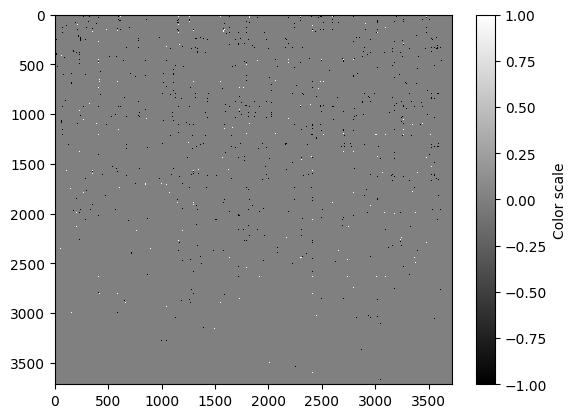

In [5]:
# Initiate a new user-user matrix showing every posibility of a user being reccomended to another user
n_users = 3716
user_interactions = np.zeros((n_users+1,n_users+1))

# Populate the matrix with likes and dislikes from the datas
def get_user_interactions(data):
  for i, row in data.iterrows():
    from_id = row['user_from_id']
    to_id = row['user_to_id']
    is_like = row['is_like']
    is_match = row['is_match']

    if(is_like):
      user_interactions[from_id,to_id] = 1
      # If user A got a match with user B, user B must have also liked user A. We log this, too
      if(is_match): user_interactions[to_id,from_id] = 1
    else: user_interactions[from_id,to_id] = -1

  return user_interactions  

user_interactions = get_user_interactions(train_data)


import matplotlib.pyplot as plt
plt.imshow(user_interactions,cmap='grey',
interpolation='nearest', aspect='auto')
plt.colorbar(label='Color scale')
plt.show()

The above plot shows every interaction every user could have with another user. (Or themself) The white dots are likes, and black dots are dislikes. The grey zone are all interactions that haven't happened yet, so no information.

Sometimes, the dataset contradicting itself. One entry would show user A likes user B, then another entry would show user A dislikes user B. We assumed each entry represents a user being shown to another user, and that this can happen more than once. We further assumed the entries are in temporal order. These contradictions then likely represent a user changing their mind, so the latest entry should be given precedence. This behavior is ensured in the code by simply having later entries override earlier ones.

No users have been removed. Even a user with a single dislike gives some useful information, as the algorithm can't 'get away with' randomly assigning this user high values and concluding the user simply likes everyone. While empty rows and columns provide no information and may as well be removed, there's little point to doing so. These rows and columns don't affect other ones, as they are irrelevant to the reconstruction error. Removing them could perhaps have lead to a slight positive impact on memory and time use, but this would likely not even save enough time to make up for coding it.

In [6]:
# Apply the nmf-algorithm (similar to above)
def nmf(X, n_components, max_iter, tol):
  # Eliminate negative values for nmf-algorithm (Likes are 1 here, dislikes/unknowns are 0)
  V = np.where(X == 1, 1, 0)
  # Create layermask indicating which values in the matrix are known (Likes/dislikes are 1 here, unknowns are 0)
  layermask = np.where(X == 0, 0, 1)

  W = np.random.rand(n_users+1, n_components)
  H = np.random.rand(n_components, n_users+1)
  i = 0
  E = np.inf
  Enew = np.linalg.norm((V - W@H)*layermask, 'fro') # Multiply difference matrix with layermask, so missing values don't affect reconstruction error
  while(E-Enew > tol and i < max_iter): 
    i += 1
    W *= (V@H.T) / (W@H@H.T + 1e-9) # No need to multiply V with the layermask here, unknown values in V are already set to 0
    H *= (W.T@V) / (W.T@W@H + 1e-9)

    E = Enew
    Enew = np.linalg.norm((V - W@H)*layermask, 'fro')
  return W@H


result_matrix = nmf(user_interactions, 12, 100, 1e-3)

Note the last line of the above cell. It contains the most relevant variables for the algorithm. These were balanced out experiamentally, and using 'manual' cross-validation. It would have been better to actually implement cross-validation, though. See the very bottom of this report for the corpse of our best attempt.

We now created a user-to-user matrix with values predicting whether or not that user will like the other user - including the previusly missing values.

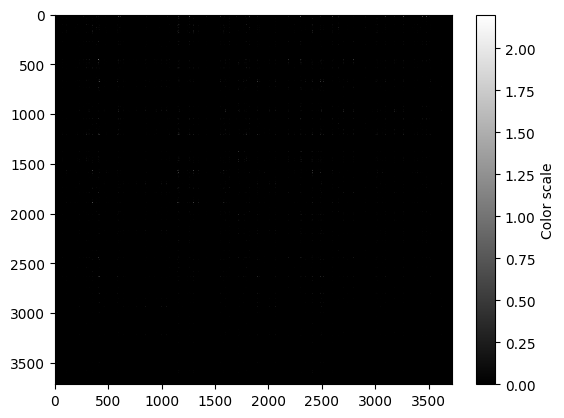

In [7]:
import matplotlib.pyplot as plt
plt.imshow(result_matrix,cmap='grey',
interpolation='nearest', aspect='auto')
plt.colorbar(label='Color scale')
plt.show()

As can be seen, the values of this matrix are all very low. This is likely because likes are much rarer than dislikes. The algorithm rightly assumes most interactions are likely to be dislikes.

For this reason, we consider a value of 0.01 to be a reasonable recommendation threshold. This value was chosen to ensure the data suggests likes with the same frequency as they appear in the training set - about 15%.

In [8]:
# Use result matrix to predict test data
def apply_matrix(matrix, apply_to):
  result = []
  for i, row in apply_to.iterrows():
    from_id = row['user_from_id']
    to_id = row['user_to_id']

    # Predict true iff the users are both known and they have a positive score
    if(from_id>n_users or to_id>n_users or matrix[from_id, to_id]<=0.01): result.append(False)
    else: result.append(True)
  return result  

prediction = apply_matrix(result_matrix,test_data)
print(prediction)
print("Frequency of likes predicted:", np.sum(prediction), "/", len(prediction))

[False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, True, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, True, False, False, False, False, True, False, False, False, False, Tr

Above is an array representing our best attempt at predicting the missing values in the test set. The indices of the array correspond to the IDs of the entries they are a prediction for.

## Distance-based recommender system

### Supporting functions

First, we define some supporting functions that wrangle our data into forms we want to use for minhashing.

You can collapse the cell below for better readability of this section, we will cover what each function does when the pipeline gets to it.

In [9]:
# Supporting functions and classes for minhashing recommender
# You can collapse this cell for better readability of the report
class RandomHashFunction(HashFunction):
    """
    UniversalHashFunction Library class HashFunction.
    This HashFunction class can be used to create an unique hash given an alpha and beta.
    """

    # BIG_PRIME is a large prime that should be less than max size for int32
    BIG_PRIME = 799833737

    def __init__(self, seed=None):
        generator = np.random.default_rng(seed)
        self.alpha = generator.integers(low=1, high=self.BIG_PRIME - 1, dtype=np.int64)
        self.beta = generator.integers(low=0, high=self.BIG_PRIME - 1, dtype=np.int64)

    def hashf(self, x: float, n: int):
        """
        Returns a hash given integers x and n.
        :param x: The value to be hashed
        :param n: The number of unique ids of all sets (modulo)
        :return: The hashed value x given alpha and beta
        """
        if n >= self.BIG_PRIME:
            raise ValueError(
                f"Max value n ({n}) should be smaller than {self.BIG_PRIME}"
            )

        return self._hashf(x) % n

    def _hashf(self, x: float):
        return (self.alpha * x + self.beta) % self.BIG_PRIME

    def __repr__(self) -> str:
        return f"RandomHashFunction(alpha={self.alpha}, beta={self.beta})"

def get_random_hash_functions(number_of_functions: int) -> list[HashFunction]:
    result = []

    incrementing_seed = None
    if Config.fixed_seed:
        incrementing_seed = Config.seed

    for i in range(0, number_of_functions):
        if Config.fixed_seed:
            incrementing_seed += 1
        result.append(RandomHashFunction(incrementing_seed))
    return result

def simple_jaccard(c1: np.ndarray, c2: np.ndarray) -> float:
    intersect_size = np.intersect1d(c1, c2).size
    union_size = np.union1d(c1, c2).size
    if union_size == 0:
        return 0
    return intersect_size / union_size

def print_k_neighbours(like_sets, user_ids, dists, k):
    sorted_dists = zip(user_ids, dists)
    sorted_dists = sorted(sorted_dists, key=lambda a: a[1], reverse=True)
    
    user_id_and_distance = sorted_dists.pop(0)
    user_id = user_id_and_distance[0]
    idx_user = user_ids.index(user_id)
    user_like_set = np.array(list(like_sets[idx_user]))
    print(f"Likeset for user {user_id}")
    print(f"  {user_id:>4} (dist={user_id_and_distance[1]:>6.2f}): {sorted(user_like_set.tolist())}")
    print(f"Likesets for closest users")
    for i in range(k):
        neighbour_id_and_distance = sorted_dists[i]
        neighbour_id = neighbour_id_and_distance[0]
        idx_neighbour = user_ids.index(neighbour_id)
        neighbour_like_set = np.array(list(like_sets[idx_neighbour]))
        jaccard_similarity = simple_jaccard(user_like_set, neighbour_like_set)
        print(f"  {neighbour_id:>4} (hashed_jaccard={neighbour_id_and_distance[1]:>6.2f}, true_jaccard={jaccard_similarity:>8.5f}):")
        print(f"  {"-":>4} their likeset: {sorted(neighbour_like_set.tolist())}")

def plot(
    df: pd.DataFrame,
    window=None,
    columns: list[str] = None,
    title="Title",
    xcolumn: str = None,
    xlabel=None,
    ylabel=None,
    figsize=(15, 8),
    loc=None,
    bbox_to_anchor=None,
):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all columns
    if columns is None:
        columns = df.columns

    if xcolumn is not None and xcolumn in columns:
        columns = columns.drop[xcolumn]

    # Plot each sensor in a different color
    plt.figure(figsize=figsize)
    for column in columns:
        plt.plot(
            df[xcolumn][start_index:end_index],
            df[column][start_index:end_index],
            label=column,
        )

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    if loc is None:
        if len(columns) < 5:
            loc = "best"
        else:
            loc = "upper right"

    if bbox_to_anchor is None:
        if loc == "best":
            bbox_to_anchor = (1.0, 1.0)
        else:
            bbox_to_anchor = (1.11, 1.0)

    plt.legend(loc=loc, bbox_to_anchor=bbox_to_anchor)

    plt.show()

def mh_get_likesets(df: pd.DataFrame) -> list[Tuple[int, set[int]]]:
        max_id = -sys.maxsize

        for _, row in df.iterrows():
            from_id = row["user_from_id"]
            to_id = row["user_to_id"]

            max_id = max(max_id, from_id)
            max_id = max(max_id, to_id)
        
        max_id += 1

        result: list[Tuple[int, set[int]]] = []
        result = [(i, set()) for i in range(0, max_id)]

        for _, row in df.iterrows():
            from_id = row["user_from_id"]
            to_id = row["user_to_id"]
            is_like: bool = row["is_like"]
            is_match: bool = row["is_match"]

            if is_like:
                result[from_id][1].add(to_id)
            # We decided to also check for matches, because it appears if there is a match, we don't have the like data point for the reverse pair
            # Sidenote: if we do have the datapoint, it doesn't matter, because repeated entries cannot exist in sets anyway
            if is_match:
                result[to_id][1].add(from_id)

        return result

def mh_remove_empty_sets(user_ids, user_likes) -> None:
        empty_indices = []
        for i, likeset in enumerate(user_likes):
            if len(likeset) == 0:
                empty_indices.append(i)

        if Config.do_print: print(f"Will remove {len(empty_indices)} empty likesets")

        for i in sorted(empty_indices, reverse=True):
            user_ids.pop(i)
            user_likes.pop(i)

        if Config.do_print: print(
            f"Resuming recommendation pipeline with {len(user_likes)} likesets for {len(user_ids)} users"
        )



### Start of Pipeline

Since minhashing is a way to approximate Jaccard similarity, we need to do some preprocessing to the data to get it into sets.

We will consider the sets of likes for each user, called a ***likeset*** for a user. We will write a pipeline that computes *likeset* signatures through minhashing, and then we will calculate Jaccard similarities of each signature to all signatures to get a similarity matrix.

Given a user $a$ with likeset $A$, the $k$ nearest neighbours of $a$: that is the users $b_k$ with the highest similarity in their likesets $B_k$ to $A$, will have some overlap in likes with user $a$ and some users that are not present in $A$. The users in the likesets of $a$'s nearest neighbours that are disjoint from $A$ are expected to be good recommendations to show to user $a$.

Good recommendations are thus $R$, the set of users not liked by $a$ but liked by at least one of their $k$ nearest neighbours. Given by

$$
    R = \left( \bigcup_{i \in \{0 \dots k\}} B_i \right) \setminus A
$$

In [10]:
# First, we want to get the set of users each user liked
# user_ids_and_likes is a list of tuples: (int, set[int])
# The tuples contain the user ID, and the set of all user IDs liked by this user in the provided dataset
user_ids_and_likes = mh_get_likesets(train_data)

# Next, we will unzip this list of tuples into two lists:
# - user_ids is a list of user ids
# - user_likes is a list of likesets
# They share indices, so user_likes_sets[i] has the likeset for user_id user_likes_ids[i]
user_ids, user_likes = map(list, (zip(*user_ids_and_likes)))

if Config.do_print: print(f"Aquired {len(user_likes)} likesets for {len(user_ids)} users")

# Some users have not liked anybody. This can result in weird recommendations for new users, or existing users that haven't liked anybody either.
# We will remove all users that haven't liked anybody.
mh_remove_empty_sets(user_ids, user_likes)

Aquired 3717 likesets for 3717 users
Will remove 1312 empty likesets
Resuming recommendation pipeline with 2405 likesets for 2405 users


Now that we have our dataset in a format we can use with minhashing (i.e. sets), we move on to getting the minhash signatures.  
We define a number of hashing functions to be 500. We found this to be a good compromise between accuracy and speed.  
In a future chapter, we will show examples to support this.

The full pipeline runs in 9,8 seconds on our machine from raw in-memory data to finished distance matrix. Nearest neighbours and recommendations take a fraction of a second after that.  

In [11]:
# We get our random hashing functions.
# They are defined as random initializations for the universal hashing function in the slides
# hash(x, a, b) = ((ax + b) mod p) mod m
# - a is a random number in range [1, p-1]
# - a is a random number in range [0, p-1]
# - p is a large prime number
# - m is the maximum value for the hash code
# in our case, p = 799833737
number_of_hash_functions = 500
hash_functions = get_random_hash_functions(number_of_hash_functions)
hash_signatures = compute_signature(hash_functions, user_likes)

if Config.do_print: print(f"Aquired hash signatures for {len(user_ids)} users")

number_distinct_ids=2154
Aquired hash signatures for 2405 users


In the above code we calculated the minhashes for our user columns. Now, we will calculate the Jaccard index, or Jaccard similarity, between every possible pair of hash columns. In other words, the similarity between ever pair or user hashes.

In [12]:
# Calculate Jaccard dissimilarity/distance with scipy pairwise distance
hashed_jaccard_sim = pdist(hash_signatures.T, 'jaccard')

# Distances are in lower triangular form, we want square form for ease of use.
hashed_jaccard_sim = squareform(hashed_jaccard_sim)

# We want the Jaccard simmilarity, not the Jaccard dissimilarity.
# We can obtain this by simply taking the inverse.
hashed_jaccard_sim = 1 - hashed_jaccard_sim
print(f"Calculated similarity matrix: {hashed_jaccard_sim.shape}")

# We should now have similarities in hashed_jaccard_sim
# Where hashed_jaccard_sim[i][j] == hashed_jaccard_sim[j][i] == approximated Jaccard similarity of user i and user j likesets.

Calculated similarity matrix: (2405, 2405)


We have calculated the Jaccard similarity of the hashed user likesets.  
The Jaccard similarity of the hashed sets approximates the true Jaccard similarity between the original user likesets.

To see this, we can look at an example user and compare their true Jaccard similarities to all likesets in the dataset with the approximated Jaccard similarity to all hashed likesets in the dataset. We will look at the user with ID `80`.

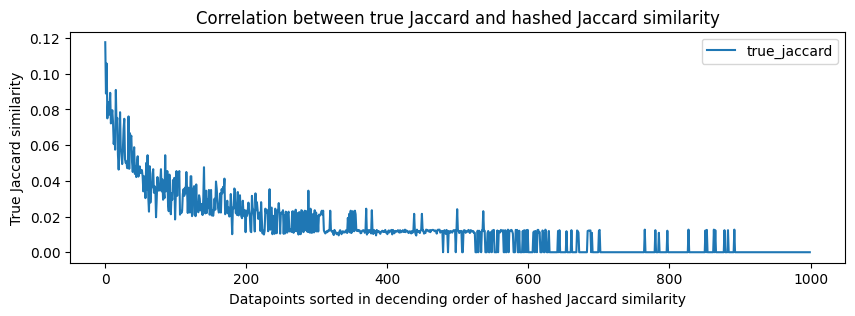

Likeset for user 80
    80 (dist=  1.00): [2, 6, 29, 50, 58, 90, 156, 192, 194, 202, 224, 259, 268, 325, 391, 396, 400, 460, 470, 499, 506, 625, 668, 684, 755, 832, 860, 1003, 1074, 1156, 1161, 1174, 1199, 1204, 1259, 1449, 1478, 1633, 1648, 1717, 1734, 1778, 1825, 1911, 1959, 2064, 2197, 2217, 2236, 2254, 2355, 2370, 2427, 2446, 2488, 2535, 2550, 2589, 2674, 2699, 2723, 2746, 2940, 2967, 2973, 3010, 3112, 3136, 3260, 3276, 3320, 3330, 3423, 3477, 3478, 3532, 3545, 3594, 3614]
Likesets for closest users
    19 (hashed_jaccard=  0.14, true_jaccard= 0.11765):
     - their likeset: [2, 6, 26, 70, 100, 111, 400, 594, 625, 695, 709, 886, 1070, 1164, 1398, 1538, 1622, 1745, 1754, 1792, 1825, 1959, 2194, 2269, 2370, 2377, 2550, 2723, 2867, 2940, 2973, 3006, 3155, 3335, 3477]
    36 (hashed_jaccard=  0.11, true_jaccard= 0.08889):
     - their likeset: [499, 577, 1259, 1594, 1648, 1682, 1745, 1901, 2197, 2370, 2422, 2910, 2973, 2998, 3136, 3276, 3335, 3493, 3565]
    93 (hashed_jaccard=  0.11, 

In [13]:
def graph_true_jaccard_in_hashed_distance_order(like_sets, user_ids, dists, plt_window=(0, 1000), plt_title="Correlation between true Jaccard and hashed Jaccard similarity"):
    sorted_dists = zip(user_ids, dists)
    sorted_dists = sorted(sorted_dists, key=lambda a: a[1], reverse=True)
    
    # print(sorted_dists)

    user_id_and_distance = sorted_dists.pop(0)
    user_id = user_id_and_distance[0]
    idx_user = user_ids.index(user_id)
    user_like_set = np.array(list(like_sets[idx_user]))

    data = {"index": [], "id": [], "hash_jaccard": [], "true_jaccard": []}
    for i in range(len(sorted_dists)):
        id_and_distance = sorted_dists[i]
        id = id_and_distance[0]
        hash_jaccard = id_and_distance[1]
        idx_id = user_ids.index(id)
        neighbour_like_set = np.array(list(like_sets[idx_id]))
        true_jaccard = simple_jaccard(user_like_set, neighbour_like_set)

        data["index"].append(i)
        data["id"].append(id)
        data["hash_jaccard"].append(hash_jaccard)
        data["true_jaccard"].append(true_jaccard)

    df = pd.DataFrame(data)
    # print(df)
    plot(
        df,
        window=plt_window,
        columns=["true_jaccard"],
        title=plt_title,
        xcolumn="index",
        xlabel="Datapoints sorted in decending order of hashed Jaccard similarity",
        ylabel="True Jaccard similarity",
        figsize=(10, 3)
    )

# Get the index of user ID 80 in the user_ids and user_likes lists
idx_of_user_80 = user_ids.index(80)
# Obtain the hashed Jaccard similarities of user 80 to all other hashed likesets
user_80_dists = hashed_jaccard_sim[idx_of_user_80,:].tolist()

# Graph the hashed Jaccard similarity in the order of high to low true Jaccard similarity
graph_true_jaccard_in_hashed_distance_order(user_likes, user_ids, user_80_dists)
print_k_neighbours(user_likes, user_ids, user_80_dists, 5)

As you can see in the graph, the true Jaccard similarity is graphed on the y-axis, with high-to-low sorted indices of hashed Jaccard similarity on the x-axis.  
The first 5 neighbours of user 80 are also printed with their hashed_jaccard to user 80's hashed likeset, the true_jaccard between their unhashed, full likesets.  
The full likesets are also printed, and from this we can see the overlapping values, and the non-overlapping values we may recommend to user 80 in the future.

As we expect, a high Jaccard similarity to user 80's hashed likeset (left) corresponds to a high true Jaccard similarity of user 80's likeset and the same likeset as the hashed index with a high hashed similarity.

As the Jaccard similarity of the hashed sets gets lower (left to right), the true Jaccard similarity between the same sets also declines, in general.

There is some noise, this is to be expected because we're taking an approximation, and especially at the tail end, there are some `0.02` true Jaccard index datapoints which hash lower than other `0.00` true Jaccard index points.

We are happy with this result though, because in a recommendation system, only the nearest neighbours really matter. From their likesets, we can take some unseen people and serve them to user 80. 

In [14]:
# Below is the entire pipeline in a single function, mostly uncommented.
# For the comments explaining the pipeline, please see the step-by-step above.
def minhash_pipeline(data: pd.DataFrame, number_of_hash_functions: int = 500):
    # user_ids_and_likes is a list of tuples: (int, set[int])
    user_ids_and_likes = mh_get_likesets(data)

    # user_ids is a list of user ids
    # user_likes is a list of likesets
    user_ids, user_likes = map(list, (zip(*user_ids_and_likes)))
    if Config.do_print: print(f"Aquired {len(user_likes)} likesets for {len(user_ids)} users")
    mh_remove_empty_sets(user_ids, user_likes)
    
    hash_functions = get_random_hash_functions(number_of_hash_functions)
    hash_signatures = compute_signature(hash_functions, user_likes)

    # strings = hash_signatures.T.tolist()
    # strings = [f"  {user_ids[i]:>4}: {elem}" for (i, elem) in enumerate(strings)]
    if Config.do_print: print(f"Aquired hash signatures for {len(user_ids)} users")
    
    hashed_jaccard_sim = pdist(hash_signatures.T, 'jaccard')
    hashed_jaccard_sim = squareform(hashed_jaccard_sim)
    hashed_jaccard_sim = 1 - hashed_jaccard_sim
    if Config.do_print: print(f"Calculated similarity matrix: {hashed_jaccard_sim.shape}")
    
    return (user_ids, user_likes, hashed_jaccard_sim)

### Number of hash functions

We will now show a few different settings for the number of hash functions and their results in the same type of graph as above, true Jaccard similarity of user 80 to all true sets plotted, on an x-axis in left-to-right high-to-low order of the hashed Jaccard similarities.

1 hashes took 12.174666 seconds


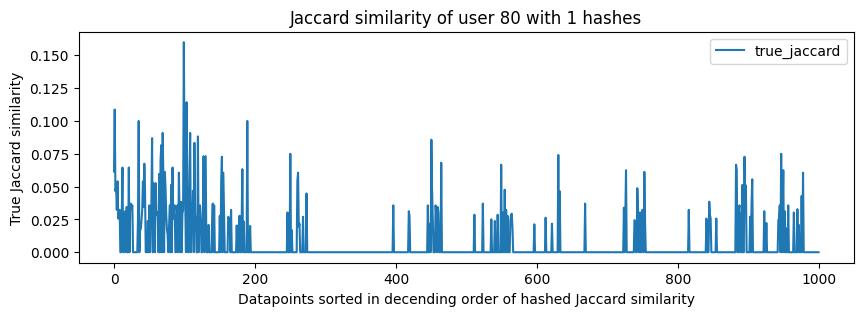

5 hashes took 11.578951 seconds


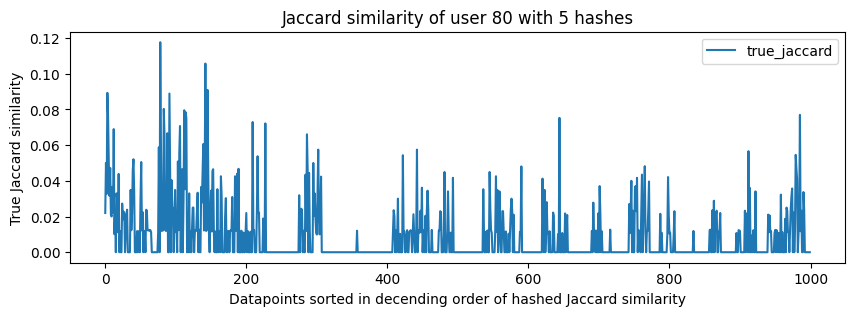

10 hashes took 12.855446 seconds


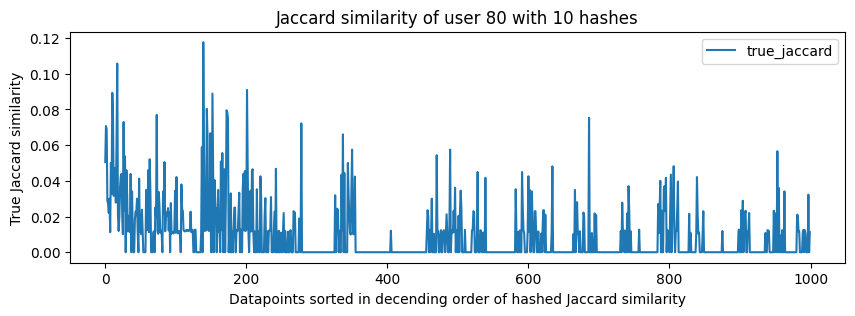

50 hashes took 12.347202 seconds


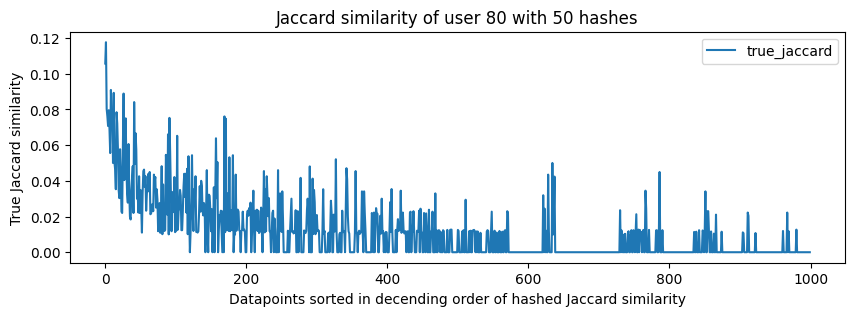

100 hashes took 16.471848 seconds


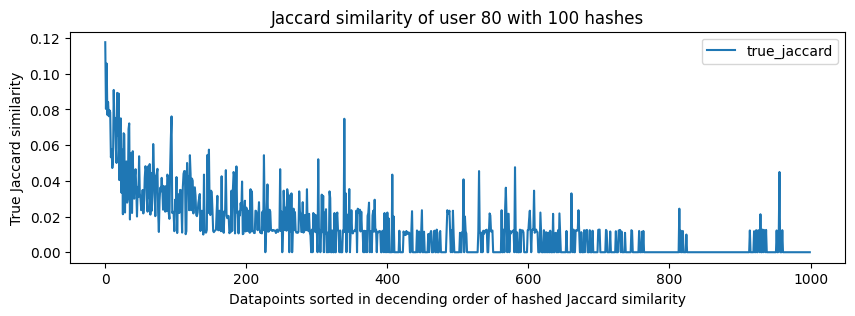

500 hashes took 49.373877 seconds


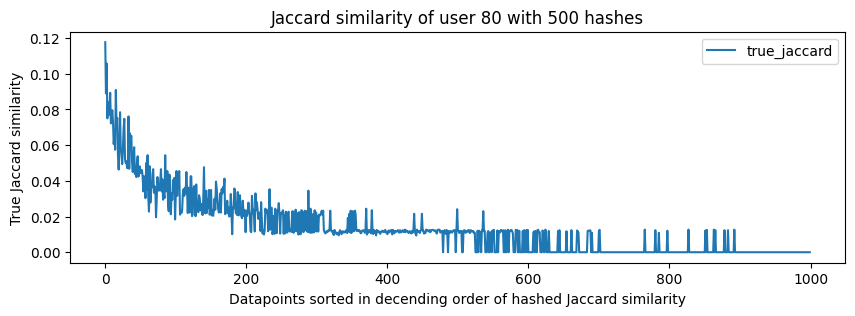

In [15]:
def mh_demo_number_of_hashes():
    old_print_const = Config.do_print
    Config.do_print = False
    hash_numbers = [1, 5, 10, 50, 100, 500]
    
    for hash_number in hash_numbers:
        start_time = datetime.now()
        user_ids, user_likes, hashed_jaccard_sim = minhash_pipeline(train_data, hash_number)
        end_time = datetime.now()
        algo_time = end_time - start_time
        algo_time = algo_time.total_seconds()
        print(f"{hash_number} hashes took {algo_time} seconds")
    
        # Get the index of user ID 80 in the user_ids and user_likes lists
        idx_of_user_80 = user_ids.index(80)
        # Obtain the hashed Jaccard similarities of user 80 to all other hashed likesets
        user_80_dists = hashed_jaccard_sim[idx_of_user_80,:].tolist()

        # Graph the hashed Jaccard similarity in the order of high to low true Jaccard similarity
        graph_true_jaccard_in_hashed_distance_order(user_likes, user_ids, user_80_dists, plt_title=f"Jaccard similarity of user 80 with {hash_number} hashes")
    Config.do_print = old_print_const
    
mh_demo_number_of_hashes()

As is visible, with 1 hash the data is quite random, although there is some clustering of the high true hashes to the left already showing even with only 1 hash function.  
As the number of hashes increase, the quality of the approximation also increases, ending up with the same graph for 500 hashes as the earlier graph for user 80.

If we continue increasing:

500 hashes took 45.577237 seconds


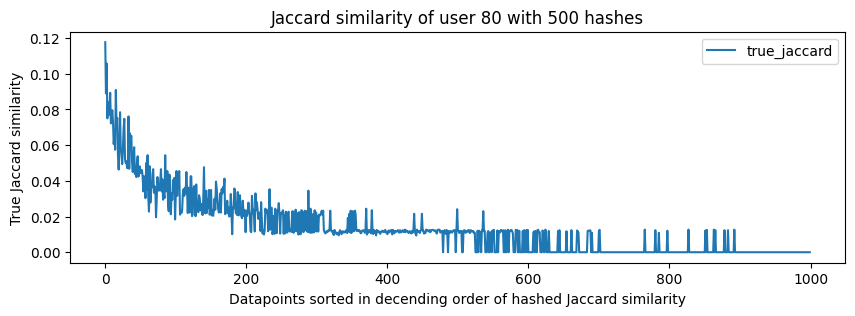

1000 hashes took 88.60905 seconds


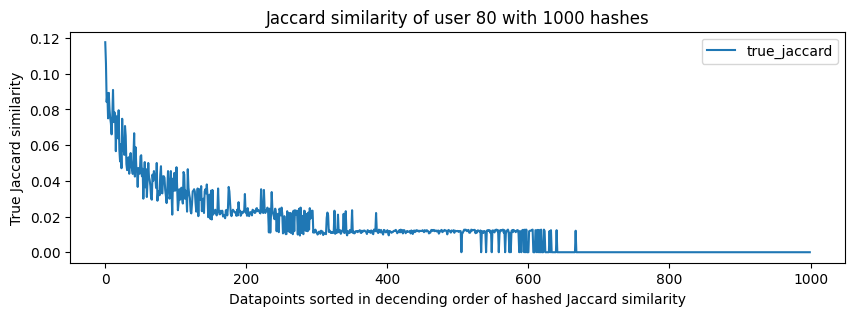

1500 hashes took 122.729963 seconds


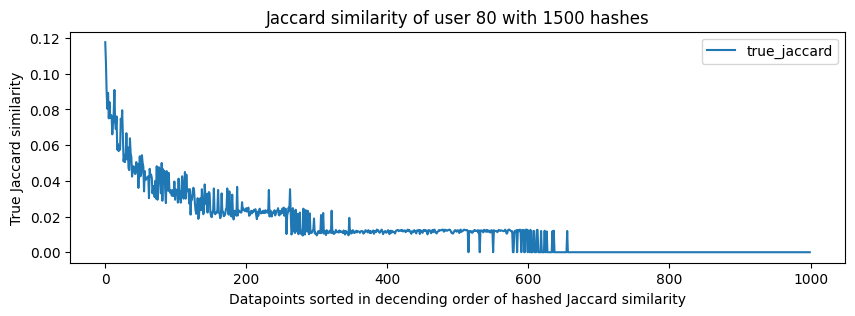

2000 hashes took 78.275854 seconds


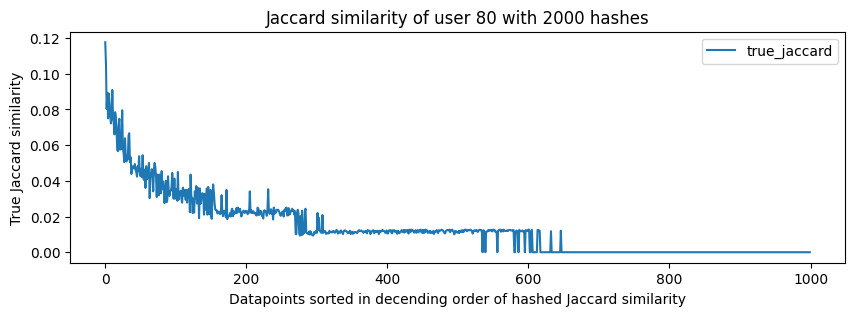

3000 hashes took 119.390231 seconds


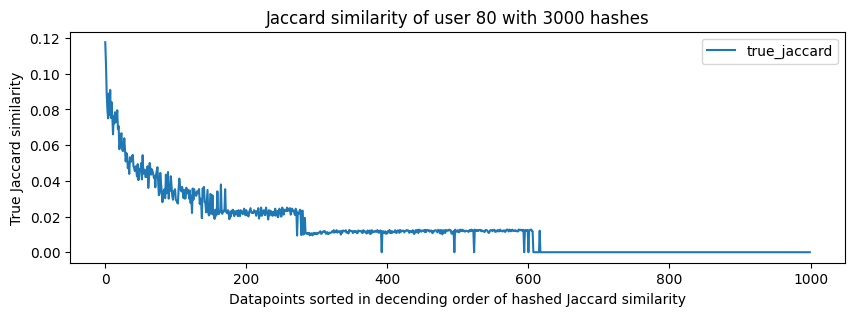

In [16]:
def mh_demo_number_of_hashes_higher():
    old_print_const = Config.do_print
    Config.do_print = False
    hash_numbers = [500, 1000, 1500, 2000, 3000]
    
    for hash_number in hash_numbers:
        start_time = datetime.now()
        user_ids, user_likes, hashed_jaccard_sim = minhash_pipeline(train_data, hash_number)
        end_time = datetime.now()
        algo_time = end_time - start_time
        algo_time = algo_time.total_seconds()
        print(f"{hash_number} hashes took {algo_time} seconds")
    
        # Get the index of user ID 80 in the user_ids and user_likes lists
        idx_of_user_80 = user_ids.index(80)
        # Obtain the hashed Jaccard similarities of user 80 to all other hashed likesets
        user_80_dists = hashed_jaccard_sim[idx_of_user_80,:].tolist()

        # Graph the hashed Jaccard similarity in the order of high to low true Jaccard similarity
        graph_true_jaccard_in_hashed_distance_order(user_likes, user_ids, user_80_dists, plt_title=f"Jaccard similarity of user 80 with {hash_number} hashes")
    Config.do_print = old_print_const
    
mh_demo_number_of_hashes_higher()

As the number of hash functions goes up, so does the quality of the approximation.  

At values higher than 500 though, it's quickly increasing the runtime of the algorithm to a point where it's not acceptable anymore, up to 38.23 seconds for 3000 hashes on our machine. At 3000 hashes, we're even increasing the resolution of our dataset, as we have about 2 400 non-empty likesets.

We believe 500 hashes is a good sweet spot for low runtime and high enough accuracy of the approximation.

### Recommendations in the training data

Continuing with our example user 80, the recommendations have been part of the printed code output above, but to highlight what's happening, we'll go through it here.

In [17]:
def mh_get_recommendations(data: pd.DataFrame, user_id: int, k: int = 3):
    # Run the pipeline
    user_ids, user_likes, hashed_jaccard_sim = minhash_pipeline(data)
    
    # Get index of our user_id and distances for that user
    idx_user_id = user_ids.index(user_id)
    user_dists = hashed_jaccard_sim[idx_user_id,:].tolist()
    
    # Sort the distances in decreasing order of similarity (highly similar users: their likes are good recommendations)
    sorted_user_dists = zip(user_ids, user_dists)
    sorted_user_dists = sorted(sorted_user_dists, key=lambda a: a[1], reverse=True)
    
    # Nearest k neighbours are usually the range 0:k
    # But, the user itself is also in the sorted distances, so we need to skip over index 0, which makes it 1:k+1
    nearest_k_users = sorted_user_dists[1:k+1]
    
    if Config.do_print: print(f"Retrieved {len(nearest_k_users)}-nearest users for user {user_id}")
    
    # Get the set of likes for our user_id
    user_like_set = np.array(list(user_likes[idx_user_id]))
    
    # Get the set of likes for our nearest-k
    nearest_likes = set()
    for i in range(len(nearest_k_users)):
        neighbour_id_and_distance = sorted_user_dists[i]
        neighbour_id = neighbour_id_and_distance[0]
        idx_neighbour = user_ids.index(neighbour_id)
        neighbour_like_set = np.array(list(user_likes[idx_neighbour]))
        for like in neighbour_like_set:
            nearest_likes.add(like)
    
    # Remove ids our user already liked
    # Remaining are liked users for our nearest neighbours that our user hasn't liked yet
    # These are good recommendations for our user, as they are more likely to also like them, because similar users to our user also liked these.
    recommendations = nearest_likes.difference(user_like_set)
    
    print_k_neighbours(user_likes, user_ids, user_dists, 3)
    
    print()
    print("===== Output =====")
    print(f"Found {len(recommendations)} recommendations for user {user_id} from their {len(nearest_k_users)} nearest neighbours' likes.")
    print(f"{len(nearest_likes)} neighbours' likes were under consideration, but {len(nearest_likes)-len(recommendations)} intersecting likes with user {user_id} were removed.")
    print(f"The recommendations are:")
    print(f" - {sorted(list(recommendations))}")
    
    return recommendations

recommendations = mh_get_recommendations(train_data, user_id=80, k = 3)

Aquired 3717 likesets for 3717 users
Will remove 1312 empty likesets
Resuming recommendation pipeline with 2405 likesets for 2405 users
number_distinct_ids=2154
Aquired hash signatures for 2405 users
Calculated similarity matrix: (2405, 2405)
Retrieved 3-nearest users for user 80
Likeset for user 80
    80 (dist=  1.00): [2, 6, 29, 50, 58, 90, 156, 192, 194, 202, 224, 259, 268, 325, 391, 396, 400, 460, 470, 499, 506, 625, 668, 684, 755, 832, 860, 1003, 1074, 1156, 1161, 1174, 1199, 1204, 1259, 1449, 1478, 1633, 1648, 1717, 1734, 1778, 1825, 1911, 1959, 2064, 2197, 2217, 2236, 2254, 2355, 2370, 2427, 2446, 2488, 2535, 2550, 2589, 2674, 2699, 2723, 2746, 2940, 2967, 2973, 3010, 3112, 3136, 3260, 3276, 3320, 3330, 3423, 3477, 3478, 3532, 3545, 3594, 3614]
Likesets for closest users
    19 (hashed_jaccard=  0.14, true_jaccard= 0.11765):
     - their likeset: [2, 6, 26, 70, 100, 111, 400, 594, 625, 695, 709, 886, 1070, 1164, 1398, 1538, 1622, 1745, 1754, 1792, 1825, 1959, 2194, 2269, 2370, 

As you can see in the output above, we found the same 3 nearest neighbours for user 80 as before: user 19, 36 and 93.

As they are the most similar users to user 80, there is some overlap in their likes. Our recommendation set is the difference between (the union of neighbour sets) and user 80's likes.

### A new demo user

The assignment also asks to give recommendations for a new user. To continue with our ongoing example, we will append a demo user to our data with a few overlapping likes with user 80. We expect the pipeline to find 80 as it's nearest neighbour, and recommend similar users.

In [18]:
def mh_get_recommendations_for_demo_user(data: pd.DataFrame, user_id: int, k: int = 3):
    # --- Here we inject our new demo user ---
    # We give a new user (id = 4444) 10 likes that user 80 has also liked
    new_data = data.copy(deep=True)
    new_data.loc[len(new_data)] = [4444, 2, True, False]
    new_data.loc[len(new_data)] = [4444, 6, True, False]
    new_data.loc[len(new_data)] = [4444, 29, True, False]
    new_data.loc[len(new_data)] = [4444, 50, True, False]
    new_data.loc[len(new_data)] = [4444, 58, True, False]
    new_data.loc[len(new_data)] = [4444, 90, True, False]
    new_data.loc[len(new_data)] = [4444, 156, True, False]
    new_data.loc[len(new_data)] = [4444, 192, True, False]
    new_data.loc[len(new_data)] = [4444, 194, True, False]
    new_data.loc[len(new_data)] = [4444, 202, True, False]

    # Run the pipeline
    user_ids, user_likes, hashed_jaccard_sim = minhash_pipeline(new_data)
       
    # Get index of our user_id and distances for that user
    idx_user_id = user_ids.index(user_id)
    user_dists = hashed_jaccard_sim[idx_user_id,:].tolist()
    
    # Sort the distances in decreasing order of similarity (highly similar users: their likes are good recommendations)
    sorted_user_dists = zip(user_ids, user_dists)
    sorted_user_dists = sorted(sorted_user_dists, key=lambda a: a[1], reverse=True)
    
    # Nearest k neighbours are usually the range 0:k
    # But, the user itself is also in the sorted distances, so we need to skip over index 0, which makes it 1:k+1
    nearest_k_users = sorted_user_dists[1:k+1]
    
    if Config.do_print: print(f"Retrieved {len(nearest_k_users)}-nearest users for user {user_id}")
    
    # Get the set of likes for our user_id
    user_like_set = np.array(list(user_likes[idx_user_id]))
    
    # Get the set of likes for our nearest-k
    nearest_likes = set()
    for i in range(len(nearest_k_users)):
        neighbour_id_and_distance = sorted_user_dists[i]
        neighbour_id = neighbour_id_and_distance[0]
        idx_neighbour = user_ids.index(neighbour_id)
        neighbour_like_set = np.array(list(user_likes[idx_neighbour]))
        for like in neighbour_like_set:
            nearest_likes.add(like)
    
    # Remove ids our user already liked
    # Remaining are liked users for our nearest neighbours that our user hasn't liked yet
    # These are good recommendations for our user, as they are more likely to also like them, because similar users to our user also liked these.
    recommendations = nearest_likes.difference(user_like_set)
    
    print_k_neighbours(user_likes, user_ids, user_dists, 3)
    
    print()
    print("===== Output =====")
    print(f"Found {len(recommendations)} recommendations for user {user_id} from their {len(nearest_k_users)} nearest neighbours' likes.")
    print(f"{len(nearest_likes)} neighbours' likes were under consideration, but {len(nearest_likes)-len(recommendations)} intersecting likes with user {user_id} were removed.")
    print(f"The recommendations are:")
    print(f" - {sorted(list(recommendations))}")
    
    return recommendations

recommendations = mh_get_recommendations_for_demo_user(train_data, user_id=4444, k = 3)

Aquired 4445 likesets for 4445 users
Will remove 2039 empty likesets
Resuming recommendation pipeline with 2406 likesets for 2406 users
number_distinct_ids=2154
Aquired hash signatures for 2406 users
Calculated similarity matrix: (2406, 2406)
Retrieved 3-nearest users for user 4444
Likeset for user 4444
  4444 (dist=  1.00): [2, 6, 29, 50, 58, 90, 156, 192, 194, 202]
Likesets for closest users
    80 (hashed_jaccard=  0.13, true_jaccard= 0.12658):
     - their likeset: [2, 6, 29, 50, 58, 90, 156, 192, 194, 202, 224, 259, 268, 325, 391, 396, 400, 460, 470, 499, 506, 625, 668, 684, 755, 832, 860, 1003, 1074, 1156, 1161, 1174, 1199, 1204, 1259, 1449, 1478, 1633, 1648, 1717, 1734, 1778, 1825, 1911, 1959, 2064, 2197, 2217, 2236, 2254, 2355, 2370, 2427, 2446, 2488, 2535, 2550, 2589, 2674, 2699, 2723, 2746, 2940, 2967, 2973, 3010, 3112, 3136, 3260, 3276, 3320, 3330, 3423, 3477, 3478, 3532, 3545, 3594, 3614]
  2025 (hashed_jaccard=  0.12, true_jaccard= 0.10000):
     - their likeset: [202]
   

As you can see above, the demo user with 10 likes that user 80 also liked finds user 80 as one of it's three nearest neighbours, and the pipeline is able to recommend further users that this new user might like given on their approximated hashed similarity to other users' likesets.

# End of Report

# Random bits of code
Not necessarily applicable to the assignment, but preserved for posterity

You can collapse the "*Random bits of code*" header to hide all the below.

## The below code is not for grading

## Stop reading unless you're morbidly curious in discarded code

## Old functions
Some functions turned out to be unnecessary. They are preserved here in case they are needed anyway.

### Min-hashing

In [19]:
# First, we will build our user-user likes matrix
# We want a matrix of n x n, where the columns are the users, and the rows are their like record for the other users
# - n       : number of users
# - cells   : number of likes from col_user to row_user, -inf if missing, -1 if not liked


# We need a count of True likes for (from_user, to_user) pairs
def get_user_pair_values(
    df: pd.DataFrame, value_of_like=1, value_of_dislike=0
) -> dict[Tuple[int, int], int]:
    """
    Get the count of likes for every pair of users in a dataframe

    Parameters
    ----------
    df (DataFrame) : Dataframe containing columns `user_from_id : int`, `user_to_id : int` and `is_like : bool`

    Returns
    -------
    user_pair_likes : dict[(int, int), int]
        Dict of the count of likes for the pair (`from_user`, `to_user`)
    """
    result_dict: dict[Tuple[int, int], int] = dict()

    for i, row in train_data.iterrows():
        from_id: int = row["user_from_id"]
        to_id: int = row["user_to_id"]
        is_like: bool = row["is_like"]

        tuple = (from_id, to_id)

        relation_value = value_of_like if is_like else value_of_dislike

        if tuple in result_dict:
            result_dict[tuple] += relation_value
        else:
            result_dict[tuple] = relation_value
    return result_dict

user_likes_dict = get_user_pair_values(train_data, value_of_like=1, value_of_dislike=0)

def get_max_dict_tuple_key(dictionary: dict[Tuple[int, int], Any]) -> int:
    """
    For an input dictionary that has keys of (int, int), return the max value on either side of the tuple.
    """    
    indices = np.array(list(dictionary.keys()))

    m, n = indices.max(0) # max extents of indices to decide o/p array
    m = max(m, n)
    return m

def dict_to_matrix(dictionary: dict) -> np.ndarray:
    """
    Creates a matrix from an input dict, where the input dict has a pair of indices as keys and as values the value for that index.

    Parameters
    ----------
    dictionary (dict) : Dictionary containing (`int`, `int`) tuple as keys, and values of the same datatype as matrix values for the key indices

    Returns
    -------
    matrix : ndarray
        Matrix with dictionary values at key int-pair (m, n) indices
    """
    indices = np.array(list(dictionary.keys()))
    values = np.array(list(dictionary.values()))

    max_id = get_max_dict_tuple_key(dictionary)
    result = np.full((max_id + 1, max_id + 1), float("-inf"))
    result[indices[:, 0], indices[:, 1]] = values

    return result

# Used to calculate the boolean matrix for mh_similarity_matrix, but mh_similarity_matrix was too slow.
# Found a way to do it with scipy after... *looks on watch*... 3 hours of debugging. Feest!
def mh_jaccard_matrix(data):
    """_summary_
    Calculates a Jaccard matrix for the data
    The matrix is m x n
    - m : number of columns in the data
    - n : number of unique elements in the data
    
    It fills the matrix with True and False based on if a column of the data contains an element of the data
    
    Example:\n
    [[0, 3]
     [1, 4]
     [2, 5]]
     
    Returns:  
    0: [[T, F]
    1:  [T, F]
    2:  [T, F]
    3:  [F, T]
    4:  [F, T]
    5:  [F, T]]
    
    Likewise:\n
    [[0, 7]
     [1, 1]]
     
    Returns:  
    0: [[T, F]
    1:  [T, T]
    7:  [F, T]]
    """
    unique_entries = np.unique(data)
    
    n = data.shape[1]
    m = unique_entries.shape[0]
    jaccard_matrix = np.zeros((m, n), dtype=bool)
    
    if DEBUG:
        print(f"Number of unique entries: {unique_entries.size}")
        print(f"unique_entries: {unique_entries}")
        print(unique_entries[0:101])
    
    for i in range(data.shape[1]):
        col = np.isin(unique_entries, data[:,i])
        
        # if DEBUG:
        #     print()
        #     print(col)
        #     print()
        
        jaccard_matrix[:,i] = col
    
    # if DEBUG: print(jaccard_matrix)
    return jaccard_matrix

# Too slow! Found a scipy way to do it
def mh_similarity_matrix(data):
    n = data.shape[1]
    out = np.eye(n)
    
    for i in range(n):
        X = data[:,i]
        for j in range(n):
            Y = data[:,j]
            out[i,j] = simple_jaccard(X, Y)
    
    # Take the inverse, because we want the similarity, not the dissimilarity scipy.spatial.distance.jaccard computes
    out = np.abs(out - 1)
    return np.abs(out - 1)

# Alternative to make a sparse matrix if necessary for RAM usage
# def get_user_to_user_like_matrix_3(A: dict) -> csr_matrix:
#     idx = np.array(list(A.keys()))
#     val = np.array(list(A.values()))

#     m, n = idx.max(0) + 1  # max extents of indices to decide o/p array
#     m = max(m, n)
#     out = csr_matrix((val, (idx[:, 0], idx[:, 1])), shape=(m, m))
#     return out


user_likes_matrix = dict_to_matrix(user_likes_dict)

# print(user_pair_values)
print(
    "user_like_matrix",
    f"shape       : {user_likes_matrix.shape}",
    f"dtype       : {user_likes_matrix.dtype}",
    f"size        : {user_likes_matrix.size}",
    f"size (bytes): {user_likes_matrix.size * user_likes_matrix.itemsize}",
    f"size (bytes): {user_likes_matrix.nbytes}",
    sep="\n  - ",
)

user_like_matrix
  - shape       : (3717, 3717)
  - dtype       : float64
  - size        : 13816089
  - size (bytes): 110528712
  - size (bytes): 110528712


## Data exploration

In [20]:
def check_repeated_pair(from_id, to_id, index):
    for i, row in train_data.iterrows():
        other_from_id = row["user_from_id"]
        other_to_id = row["user_to_id"]
        if from_id == other_from_id and other_to_id == to_id and not i == index:
            print(f"Equality found: {i}: {other_from_id}, {other_to_id}")


def check_reversed_pair(from_id, to_id):
    for i, row in train_data.iterrows():
        other_from_id = row["user_from_id"]
        other_to_id = row["user_to_id"]
        if from_id == other_to_id and other_from_id == to_id:
            print(f"Equality found: {i}: {other_from_id}, {other_to_id}")


tuple_set = set()
tuple_dict = dict()
duplicate_set = set()
count = 0

for i, row in train_data.iterrows():
    from_id = row["user_from_id"]
    to_id = row["user_to_id"]

    tuple = (from_id, to_id)
    if tuple in tuple_set:
        # print(f"{i}: {from_id},{to_id}")
        duplicate_set.add(tuple)
        count += 1
    tuple_set.add(tuple)

    if tuple in tuple_dict:
        tuple_dict[tuple] = +1
    else:
        tuple_dict[tuple] = 0

print(count)
count = 0

for key in tuple_dict:
    if tuple_dict[key] > 0:
        count += 1
        # print(key, tuple_dict[key])

# a, b, True, ---
# a, b, False, ---

print(count)


# for tuple in duplicate_set:
#     self_from_id = tuple[0]
#     self_to_id = tuple[1]
#     for (i, row) in train_data.iterrows():
#         from_id = row['user_from_id']
#         to_id = row['user_to_id']
#         # is_like = row['is_like']
#         # is_match = row['is_match']

#         print(f"{i}: {from_id}, {to_id}")
#         check_repeated_pair(from_id, to_id, i)
#         print("")

#         print("")


a = 0
b = 0
for i, row in train_data.iterrows():
    if row["is_like"]:
        a += 1
    b += 1

print(a, "/", b, "=", a / b)

4251
4246
12637 / 76392 = 0.1654230809508849


## Other

In [21]:
def func():
    W = np.array([[2, 2, 2, 2], [4, 4, 4, 4]])
    H = np.array([[1, 2, 3, 4], [4, 4, 2, 0]])
    
    e = 1e-15
    print(e)
    
    print(W)
    print(H)
    print(W/(H+e))
    print(W * H)
func()

1e-15
[[2 2 2 2]
 [4 4 4 4]]
[[1 2 3 4]
 [4 4 2 0]]
[[2.00000000e+00 1.00000000e+00 6.66666667e-01 5.00000000e-01]
 [1.00000000e+00 1.00000000e+00 2.00000000e+00 4.00000000e+15]]
[[ 2  4  6  8]
 [16 16  8  0]]


In [22]:
ids = [{1, 2, 3, 4}, {1}, {4, 5}, {1, 2, 3}, {1}]
space = set().union(*ids)
a = sorted(space)

print(np.full((0, 0), sys.maxsize))

[]


In [23]:
# # Cross-validate
# n_chunks = 10
# chunks = np.array_split(train_data, n_chunks)

# for i in range(n_chunks):
#     # Select current test chunk and synthesize train chunk from remaining chunks
#     test_chunk = chunks[i]
#     train_chunk = []
#     for j in range(n_chunks):
#         if i!=j: train_chunk.append(chunks[j])
#     # Apply all of the above code
#     print(train_chunk)
#     generated_matrix = nmf(get_user_interactions(pd.DataFrame(train_chunk)), 5, 100, 1e-3)
#     result_list = apply_matrix(generated_matrix,test_chunk)
#     score = 0
#     for j, row in test_chunk:
#         if row['is_like'] == result_list[j]: score+=1
#     print(100*score/len(test_chunk),"%")